# Segmentation of fluid on OCT



Task description: https://github.com/MoorfieldsInnovationLab/SegmentationAssignment/blob/main/README.md

In [210]:
import os
from google.colab import drive
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from keras.models import Model
from keras.layers import Activation, Input, concatenate, BatchNormalization 
from keras.layers import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers import add
from keras.layers import LeakyReLU, Reshape, Lambda
from keras.initializers import RandomNormal
import keras

## Data loader and pre-proc

128*128 images are used in this task.\
For input image, grayscale values [0, 1] is used. Binary values 0 and 1 are given to the masks.

In [11]:
drive.mount('/content/drive')
root_dir = "/content/gdrive/MyDrive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/sample.zip

In [102]:
def read_img (data_path):
  img = []
  for f in sorted(os.listdir(data_path)):
    #input_image = tf.keras.utils.load_img(os.path.join(data_path, f), color_mode='grayscale')
    input_image = cv2.imread(os.path.join(data_path, f), 0)[..., None]
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_image = tf.image.resize(input_image, (128, 128))
    img.append(input_image)

  return img

In [ ]:
oct = tf.convert_to_tensor(read_img('/content/sample/oct'))
irf = tf.convert_to_tensor(read_img('/content/sample/irf'))
srf = tf.convert_to_tensor(read_img('/content/sample/srf'))

## Visualisation

In [212]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['oct', 'irf', 'predicted_mask_irf', 'srf', 'predicted_mask_srf']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

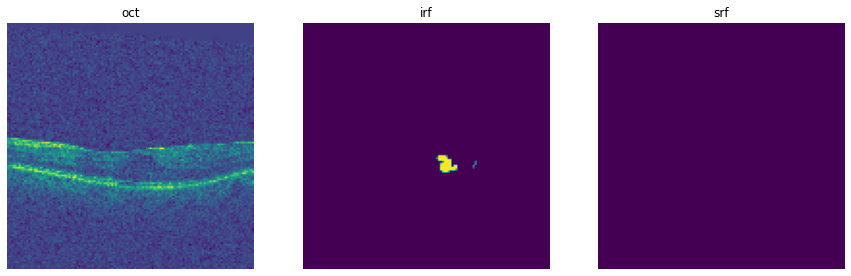

In [71]:
display_list = [oct[21], irf[21], srf[21]]
display(display_list)

## Model

A generic U-net architecture is displayed below. \
Input: 128\*128\*1 (height, width, channel) tensor \
Output: 128\*128\*1 (height, width, channel) tensor

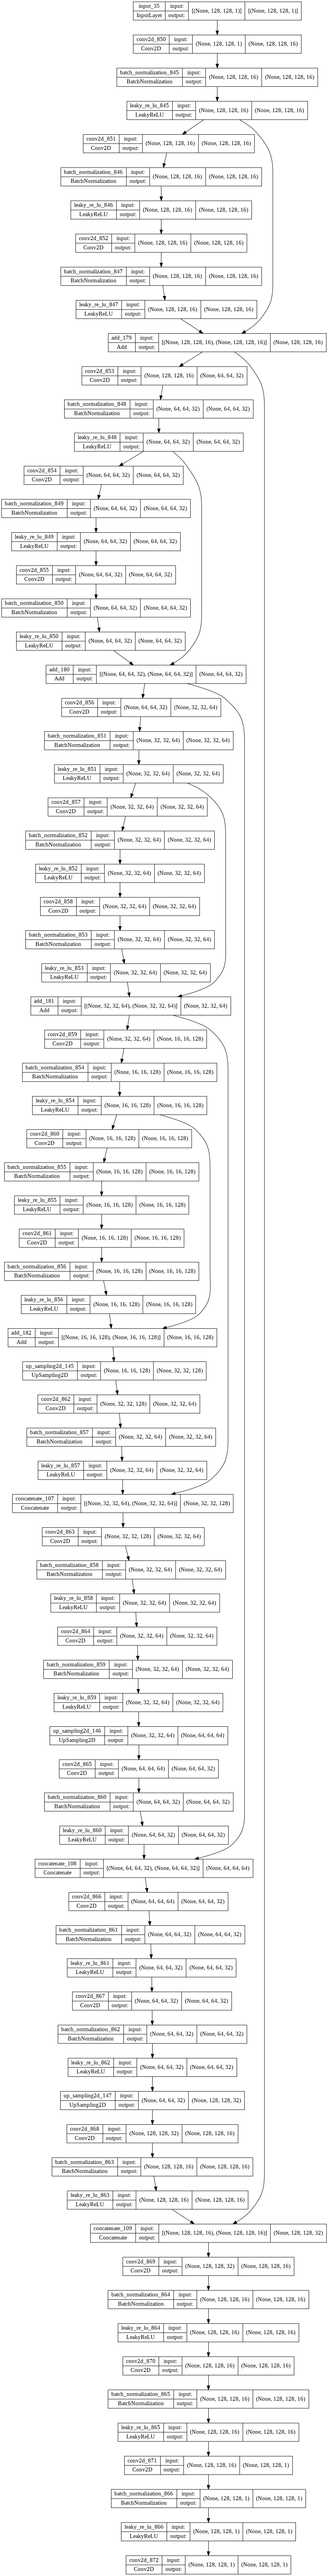

In [211]:
PATCH_SIZE = (128,128)
center = "valid" #??
BATCH_SIZE = 4
DATA_SAMPLING = 'all_positive'
vol_size = (128,128,1)

# model network 
DEPTH = 4
RESIDUAL = True
DEEP_SUPERVISION = False
FILTER_GROW = True
INSTANCE_NORM = True
NUM_CLASS = 2
BASE_FILTER = 16

#callbacks list
monitor = 'loss'#'val_loss'
mode = 'min'
early_p = 20  #the patience time to stop training while the loss is not down
reduce_lr_p = 10  #the patience time to reduce lr

min_lr = 1e-8
lr = 1e-4

def myConv(x_in, nf, strides=1, kernel_size = 3):
    """
    specific convolution module including convolution followed by leakyrelu
    """
    x_out = Conv2D(nf, kernel_size=3, padding='same',kernel_initializer='he_normal', strides=strides)(x_in)
    x_out = BatchNormalization()(x_out)
    x_out = LeakyReLU(0.2)(x_out)
    return x_out


def Unet2dBlock(l, n_feat):
    if RESIDUAL:
        l_in = l
    for i in range(2):
        l = myConv(l, n_feat)
    return add([l_in, l]) if RESIDUAL else l


def UnetUpsample(l, num_filters):
    l = UpSampling2D()(l)
    l = myConv(l, num_filters)
    return l




def unet2d(vol_size):
    inputs = Input(shape=vol_size)
    depth = DEPTH
    filters = []
    down_list = []
    deep_supervision = None
    layer = myConv(inputs, BASE_FILTER)
    
    for d in range(depth):
        if FILTER_GROW:
            num_filters = BASE_FILTER * (2**d)
        else:
            num_filters = BASE_FILTER
        filters.append(num_filters)
        layer = Unet2dBlock(layer, n_feat = num_filters)
        down_list.append(layer)
        if d != depth - 1:
            layer = myConv(layer, num_filters*2, strides=2)
        
    for d in range(depth-2, -1, -1):
        layer = UnetUpsample(layer, filters[d])
        layer = concatenate([layer, down_list[d]])
        layer = myConv(layer, filters[d])
        layer = myConv(layer, filters[d], kernel_size = 1)
        
        if DEEP_SUPERVISION:
            if 0< d < 3:
                pred = myConv(layer, NUM_CLASS)
                if deep_supervision is None:
                    deep_supervision = pred
                else:
                    deep_supervision = add([pred, deep_supervision])
                deep_supervision = UpSampling2D()(deep_supervision)
    
    layer = myConv(layer, 1, kernel_size = 1)
    
    if DEEP_SUPERVISION:
        layer = add([layer, deep_supervision])
    #layer = myConv(layer, 1, kernel_size = 1)
    #x = Activation('sigmoid', name='sigmoid')(layer)
    x = Conv2D(1, (1, 1), activation='sigmoid')(layer)
        
    model = Model(inputs=[inputs], outputs=[x])
    return model

tf.keras.utils.plot_model(unet2d(vol_size), show_shapes=True)


## Training

In the training phase, custom loss function and evaluation metrics are deployed. In the case of prodominant background, we chose dice coefficient (loss) over binary cross entropy + accuracy. There are some variations of making dice coefficient into a loss function, one could have 1-dice, -dice, or even 1-log(dice).\

Baysian optimisation or hyperband methods can be used for efficient tuning of hyperparameters. Depth and width of the network, parameters of the optimiser, smooth term in dice coefficient, batch size are all parameters that are worth investigate into.  



In [109]:
oct_train, oct_test = oct[0:140], oct[140:]
irf_train, irf_test = irf[0:140], irf[140:]
srf_train, srf_test = srf[0:140], srf[140:]

### Optimizer

In [110]:
OPTIMIZER = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
)


### Loss

In [141]:
def dice_coef(y_true, y_pred, smooth=1):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)
m = tf.keras.metrics.MeanIoU(num_classes=2)


In [ ]:
model = unet2d(vol_size)
model.compile(optimizer=OPTIMIZER,
              loss=[dice_coef_loss],
              metrics=[dice_coef])
EPOCHS = 200
VAL_SUBSPLITS = 5

model_history = model.fit(x=oct_train,
                          y=irf_train,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_split=0.2,
                          shuffle=True,
                          verbose='auto')

## Result

In [182]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=0)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [183]:
model.evaluate(oct_test, irf_test)

1/1 [==============================] - 0s 487ms/step - loss: 0.5810 - dice_coef: 0.4190


[0.5809851288795471, 0.4190148711204529]

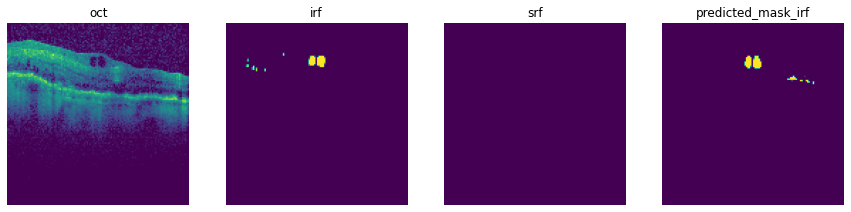

In [208]:
predict = model.predict(oct_test)

display([oct_test[2], irf_test[2], predict[2]])